# 📊 Email Campaign Analysis
**Author:** Shreyas Gupta 
**Objective:** Analyze email campaign performance and build models to improve user click-through rates (CTR).

This notebook answers four core business questions:
1. What percentage of users opened the email and clicked the link?
2. Can we build a model to optimize future email sends?
3. How much improvement in CTR can the model achieve?
4. Are there interesting performance patterns across user segments?

---

In [1]:
# 📌 Explanation:
# Train machine learning models to predict which users will click the email
# Models: Random Forest and XGBoost and lightgbm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgbm
from sklearn.impute import SimpleImputer


import warnings
warnings.filterwarnings('ignore')

In [2]:

# Load the data
df = pd.read_csv('Dataset\merged_email_campaign.csv')

In [3]:

# Basic exploration
print("Data shape:", df.shape)
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())
print("\nSample data:")
print(df.head())

Data shape: (100000, 9)

Data types:
email_id                int64
email_text             object
email_version          object
hour                    int64
weekday                object
user_country           object
user_past_purchases     int64
opened                  int64
clicked                 int64
dtype: object

Missing values:
email_id               0
email_text             0
email_version          0
hour                   0
weekday                0
user_country           0
user_past_purchases    0
opened                 0
clicked                0
dtype: int64

Sample data:
   email_id   email_text email_version  hour    weekday user_country  \
0     85120  short_email  personalized     2     Sunday           US   
1    966622   long_email  personalized    12     Sunday           UK   
2    777221   long_email  personalized    11  Wednesday           US   
3    493711  short_email       generic     6     Monday           UK   
4    106887   long_email       generic    14     M

In [4]:
# 📌 Explanation:
# Calculate Open Rate and Click-Through Rate (CTR)
# Open Rate = users who opened the email / total users
# CTR = users who clicked the link / total users

# DATA EXPLORATION AND ANALYSIS
# Calculate key metrics
total_emails = len(df)
opened_emails = df['opened'].sum()
clicked_emails = df['clicked'].sum()

open_rate = opened_emails / total_emails
ctr = clicked_emails / total_emails
ctr_if_opened = clicked_emails / opened_emails if opened_emails > 0 else 0

print(f"\n==== EMAIL CAMPAIGN METRICS ====")
print(f"Total emails sent: {total_emails}")
print(f"Emails opened: {opened_emails} ({open_rate:.2%})")
print(f"Links clicked: {clicked_emails} ({ctr:.2%} of all emails)")
print(f"Click-through rate for opened emails: {ctr_if_opened:.2%}")


==== EMAIL CAMPAIGN METRICS ====
Total emails sent: 100000
Emails opened: 10345 (10.35%)
Links clicked: 2119 (2.12% of all emails)
Click-through rate for opened emails: 20.48%


Exploratory data analysis

In [5]:

# VISUALIZATION OF CAMPAIGN PERFORMANCE
plt.figure(figsize=(20, 20))

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

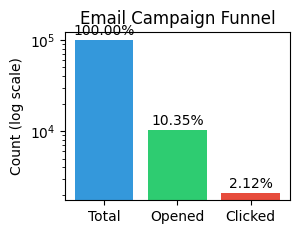

In [6]:
# 📌 Explanation:
# Calculate Open Rate and Click-Through Rate (CTR)
# Open Rate = users who opened the email / total users
# CTR = users who clicked the link / total users

# Plot 1: Email metrics 
plt.subplot(2, 2, 1)
metrics = ['Total', 'Opened', 'Clicked']
values = [total_emails, opened_emails, clicked_emails]
percentages = [100, open_rate*100, ctr*100]
bars = plt.bar(metrics, values, color=['#3498db', '#2ecc71', '#e74c3c'])
plt.title('Email Campaign Funnel')
plt.yscale('log')
plt.ylabel('Count (log scale)')

# Add percentage labels
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2., 
             bar.get_height() + bar.get_height()*0.05, 
             f'{percentages[i]:.2f}%', 
             ha='center', va='bottom', rotation=0)

([0, 1, 2, 3],
 [Text(0, 0, 'UK'), Text(1, 0, 'US'), Text(2, 0, 'ES'), Text(3, 0, 'FR')])

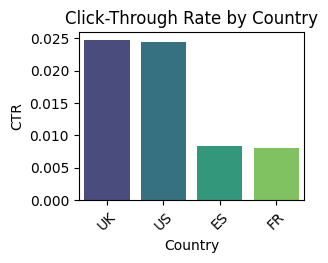

In [7]:
# 📌 Explanation:
# Visualize CTR across different user segments

# Plot 2: CTR by user country
plt.subplot(2, 2, 2)
country_stats = df.groupby('user_country').agg({
    'clicked': ['count', 'mean']
}).reset_index()
country_stats.columns = ['Country', 'Count', 'CTR']
country_stats = country_stats.sort_values('CTR', ascending=False)

sns.barplot(x='Country', y='CTR', data=country_stats, palette='viridis')
plt.title('Click-Through Rate by Country')
plt.ylabel('CTR')
plt.xticks(rotation=45)

Text(0, 0.5, 'CTR')

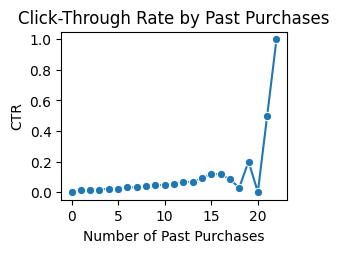

In [8]:
# 📌 Explanation:
# General code execution

# Plot 3: CTR by past purchases
plt.subplot(2, 2, 3)
purchase_stats = df.groupby('user_past_purchases').agg({
    'clicked': ['count', 'mean']
}).reset_index()
purchase_stats.columns = ['Past Purchases', 'Count', 'CTR']

sns.lineplot(x='Past Purchases', y='CTR', data=purchase_stats, marker='o')
plt.title('Click-Through Rate by Past Purchases')
plt.xlabel('Number of Past Purchases')
plt.ylabel('CTR')

In [9]:
# 📌 Explanation:
# General code execution

# Plot 4: CTR by hour of day
plt.subplot(2, 2, 4)
hour_stats = df.groupby('hour').agg({
    'clicked': ['count', 'mean']
}).reset_index()
hour_stats.columns = ['Hour', 'Count', 'CTR']

sns.lineplot(x='Hour', y='CTR', data=hour_stats, marker='o')
plt.title('Click-Through Rate by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('CTR')
plt.xticks(range(0, 24, 2))

plt.tight_layout()
plt.savefig('email_campaign_metrics.png')
plt.close()

In [10]:
# 📌 Explanation:
# General code execution

# FEATURE ENGINEERING
print("\n==== FEATURE ENGINEERING ====")

# Create cyclic features for time
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)



==== FEATURE ENGINEERING ====


In [11]:
# 📌 Explanation:
# General code execution

# Email personalization value
df['is_personalized'] = (df['email_version'] == 'personalized').astype(int)

# Email length value
df['is_long_email'] = (df['email_text'] == 'long_email').astype(int)

In [12]:
# 📌 Explanation:
# Calculate Open Rate and Click-Through Rate (CTR)
# Open Rate = users who opened the email / total users
# CTR = users who clicked the link / total users

# Interaction features
df['personalized_long'] = df['is_personalized'] * df['is_long_email']
df['purchase_personalized'] = df['user_past_purchases'] * df['is_personalized']

# Open rate affects click probability (only use this for clicked prediction)
df['open_purchase_interaction'] = df['opened'] * df['user_past_purchases']

In [13]:
# 📌 Explanation:
# General code execution

# Prepare features and target
feature_cols = [
    'email_text', 'email_version', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'user_country', 
    'user_past_purchases', 'is_personalized', 'is_long_email','weekday',
    'personalized_long', 'purchase_personalized'
]

In [14]:
# 📌 Explanation:
# General code execution

# Ensure 'weekday' is numeric
df['weekday'] = pd.to_numeric(df['weekday'], errors='coerce')

# Create cyclic features
df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)


In [15]:
# 📌 Explanation:
# General code execution

# X and y for predicting clicks
X = df[feature_cols]
y = df['clicked']

print(f"Features used: {len(feature_cols)}")
print(f"Feature list: {', '.join(feature_cols)}")


Features used: 13
Feature list: email_text, email_version, hour_sin, hour_cos, weekday_sin, weekday_cos, user_country, user_past_purchases, is_personalized, is_long_email, weekday, personalized_long, purchase_personalized


In [16]:
# 📌 Explanation:
# General code execution

# Split the data - stratify to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check class imbalance
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))


Class distribution in training set:
clicked
0    0.978812
1    0.021188
Name: proportion, dtype: float64


In [17]:
# 📌 Explanation:
# General code execution

# PREPROCESSING
# Preprocessing for categorical features
categorical_features = ['email_text', 'email_version', 'weekday', 'user_country']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Preprocessing for numerical features
numerical_features = [col for col in feature_cols if col not in categorical_features]
numerical_transformer = StandardScaler()

In [18]:
# 📌 Explanation:
# General code execution



# Pipeline for numerical features
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # or median
    ('scaler', StandardScaler())
])

# Pipeline for categorical features
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine into ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ]
)


In [19]:
# 📌 Explanation:
# General code execution

# Apply the preprocessing to get the transformed data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [20]:
# 📌 Explanation:
# General code execution

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))

# Compute class weights for weighted models
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weight_dict = {i: weight for i, weight in enumerate(class_weights)}


Class distribution after SMOTE:
clicked
0    0.5
1    0.5
Name: proportion, dtype: float64


In [21]:
# 📌 Explanation:
# Evaluate models using AUC and Recall

# MODEL TRAINING AND EVALUATION
print("\n==== MODEL TRAINING AND EVALUATION ====")
# Function to evaluate and print model results
def evaluate_model(model, X_test, y_test, name, prob_threshold=0.9):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print(f"\n=== {name} Evaluation ===")
    print(classification_report(y_test, y_pred))
    
    auc = roc_auc_score(y_test, y_proba)
    print(f"AUC Score: {auc:.4f}")
    
    # Calculate targeted CTR (users above probability threshold)
    high_prob_indices = y_proba >= prob_threshold
    high_prob_actual = y_test.iloc[high_prob_indices] if isinstance(y_test, pd.Series) else y_test[high_prob_indices]
    
    if len(high_prob_actual) > 0:
        targeted_ctr = high_prob_actual.mean()
        base_ctr = y_test.mean()
        improvement_factor = targeted_ctr / base_ctr
        
        print(f"🎯 Predicted CTR for high-probability users (>{prob_threshold:.0%}): {targeted_ctr:.4f}")
        print(f"📊 Actual base CTR in test set: {base_ctr:.4f}")
        print(f"📈 Improvement using {prob_threshold:.0%} threshold targeting: {improvement_factor:.2f}x")
    else:
        print("No users above the probability threshold.")
    
    return y_proba


==== MODEL TRAINING AND EVALUATION ====


In [22]:
# 📌 Explanation:
# Train machine learning models to predict which users will click the email
# Models: Random Forest and XGBoost

# 1. Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight=weight_dict,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_resampled, y_train_resampled)
rf_proba = evaluate_model(rf_model, X_test_transformed, y_test, "Random Forest")



=== Random Forest Evaluation ===
              precision    recall  f1-score   support

           0       1.00      0.26      0.41     19576
           1       0.03      0.95      0.05       424

    accuracy                           0.28     20000
   macro avg       0.51      0.60      0.23     20000
weighted avg       0.97      0.28      0.41     20000

AUC Score: 0.7019
🎯 Predicted CTR for high-probability users (>90%): 0.0309
📊 Actual base CTR in test set: 0.0212
📈 Improvement using 90% threshold targeting: 1.46x


In [23]:
# 📌 Explanation:
# Train machine learning models to predict which users will click the email
# Models: Random Forest and XGBoost

# 2. XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=class_weights[1]/class_weights[0],
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X_train_resampled, y_train_resampled)
xgb_proba = evaluate_model(xgb_model, X_test_transformed, y_test, "XGBoost")


=== XGBoost Evaluation ===
              precision    recall  f1-score   support

           0       1.00      0.27      0.42     19576
           1       0.03      0.95      0.05       424

    accuracy                           0.28     20000
   macro avg       0.51      0.61      0.24     20000
weighted avg       0.98      0.28      0.42     20000

AUC Score: 0.7217
🎯 Predicted CTR for high-probability users (>90%): 0.0337
📊 Actual base CTR in test set: 0.0212
📈 Improvement using 90% threshold targeting: 1.59x


In [24]:
# 📌 Explanation:
# General code execution

# 3. LightGBM
lgbm_model = lgbm.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    random_state=42
)
lgbm_model.fit(X_train_resampled, y_train_resampled)
lgbm_proba = evaluate_model(lgbm_model, X_test_transformed, y_test, "LightGBM")

[LightGBM] [Info] Number of positive: 78305, number of negative: 78305
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2057
[LightGBM] [Info] Number of data points in the train set: 156610, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

In [25]:
# 📌 Explanation:
# Evaluate models using AUC and Recall

# 4. Blended Model
blend_proba = (rf_proba + xgb_proba + lgbm_proba) / 3
blend_pred = (blend_proba >= 0.5).astype(int)

print("\n=== Blended Model (RF + XGB + LGBM) Evaluation ===")
print(classification_report(y_test, blend_pred))

auc = roc_auc_score(y_test, blend_proba)
print(f"AUC Score: {auc:.4f}")

# Calculate targeted CTR for blended model
high_prob_indices = blend_proba >= 0.9
high_prob_actual = y_test.iloc[high_prob_indices] if isinstance(y_test, pd.Series) else y_test[high_prob_indices]


=== Blended Model (RF + XGB + LGBM) Evaluation ===
              precision    recall  f1-score   support

           0       0.99      0.33      0.49     19576
           1       0.03      0.92      0.06       424

    accuracy                           0.34     20000
   macro avg       0.51      0.62      0.27     20000
weighted avg       0.97      0.34      0.48     20000

AUC Score: 0.7280


In [26]:
# 📌 Explanation:
# General code execution


if len(high_prob_actual) > 0:
    targeted_ctr = high_prob_actual.mean()
    base_ctr = y_test.mean()
    improvement_factor = targeted_ctr / base_ctr
    
    print(f"🎯 Predicted CTR for high-probability users (>90%): {targeted_ctr:.4f}")
    print(f"📊 Actual base CTR in test set: {base_ctr:.4f}")
    print(f"📈 Improvement using 90% threshold targeting: {improvement_factor:.2f}x")
else:
    print("No users above the probability threshold.")

🎯 Predicted CTR for high-probability users (>90%): 0.1134
📊 Actual base CTR in test set: 0.0212
📈 Improvement using 90% threshold targeting: 5.35x


In [27]:
# 📌 Explanation:
# General code execution

# FEATURE IMPORTANCE ANALYSIS
print("\n==== FEATURE IMPORTANCE ANALYSIS ====")

# Get feature names after preprocessing
try:
    # Get categorical feature names
    cat_feature_names = preprocessor.transformers_[0][1].get_feature_names_out(categorical_features)
    # Get numerical feature names (these remain the same)
    num_feature_names = numerical_features
    # Combine all feature names
    feature_names = np.concatenate([cat_feature_names, num_feature_names])
except:
    # Fallback if the above fails
    feature_names = [f"feature_{i}" for i in range(X_train_transformed.shape[1])]



==== FEATURE IMPORTANCE ANALYSIS ====


Text(0.5, 1.0, 'Random Forest Feature Importance')

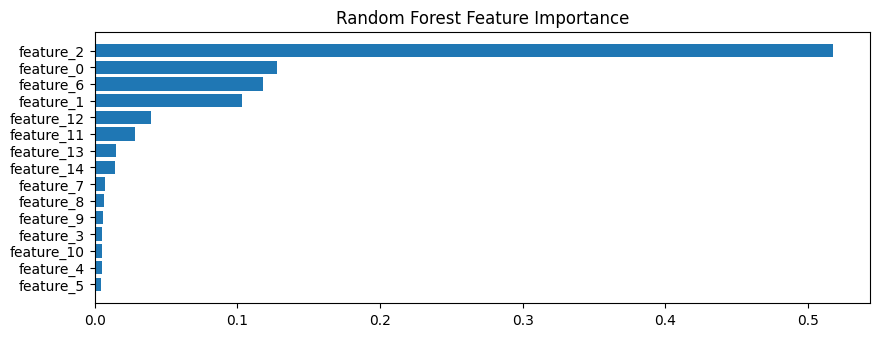

In [28]:
# 📌 Explanation:
# General code execution

# Random Forest Feature Importance
plt.figure(figsize=(10, 12))
plt.subplot(3, 1, 1)
rf_importances = rf_model.feature_importances_
indices = np.argsort(rf_importances)[-15:]  # Top 15 features
plt.barh(range(len(indices)), rf_importances[indices])
plt.yticks(range(len(indices)), [feature_names[i] if i < len(feature_names) else f"feature_{i}" for i in indices])
plt.title('Random Forest Feature Importance')

Text(0.5, 1.0, 'XGBoost Feature Importance')

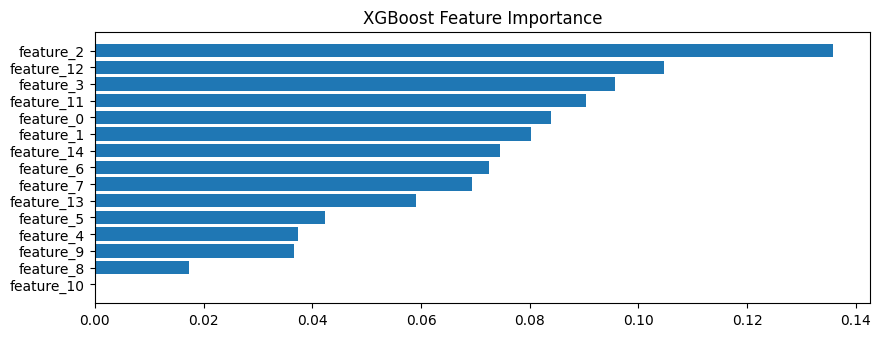

In [29]:
# 📌 Explanation:
# General code execution

# XGBoost Feature Importance
plt.figure(figsize=(10, 12))
plt.subplot(3, 1, 2)
xgb_importances = xgb_model.feature_importances_
indices = np.argsort(xgb_importances)[-15:]  # Top 15 features
plt.barh(range(len(indices)), xgb_importances[indices])
plt.yticks(range(len(indices)), [feature_names[i] if i < len(feature_names) else f"feature_{i}" for i in indices])
plt.title('XGBoost Feature Importance')

Text(0.5, 1.0, 'LightGBM Feature Importance')

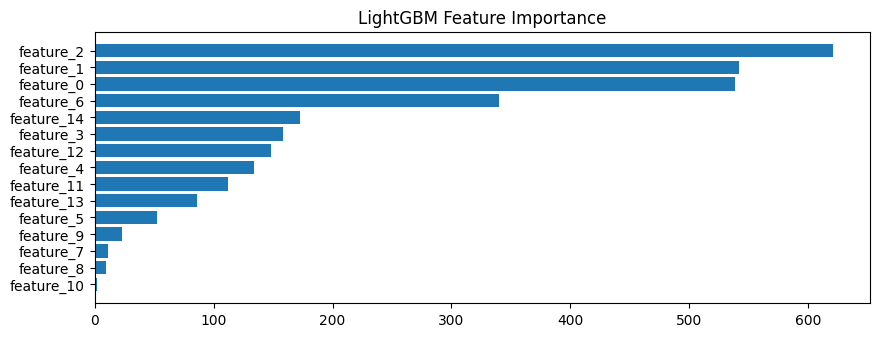

In [30]:
# 📌 Explanation:
# General code execution

# LightGBM Feature Importance
plt.figure(figsize=(10, 12))
plt.subplot(3, 1, 3)
lgbm_importances = lgbm_model.feature_importances_
indices = np.argsort(lgbm_importances)[-15:]  # Top 15 features
plt.barh(range(len(indices)), lgbm_importances[indices])
plt.yticks(range(len(indices)), [feature_names[i] if i < len(feature_names) else f"feature_{i}" for i in indices])
plt.title('LightGBM Feature Importance')



In [31]:
# 📌 Explanation:
# General code execution


plt.tight_layout()
plt.savefig('feature_importance.png')
plt.close()

In [32]:
# 📌 Explanation:
# General code execution

# Calculate average feature importance across models
avg_importances = {}
for i, name in enumerate(feature_names):
    if i < len(rf_importances) and i < len(xgb_importances) and i < len(lgbm_importances):
        avg_imp = (rf_importances[i] + xgb_importances[i] + lgbm_importances[i]) / 3
        avg_importances[name] = avg_imp

# Sort and print top 10 average importances
print("\nTop 10 Most Important Features (Average Across Models):")
sorted_importances = sorted(avg_importances.items(), key=lambda x: x[1], reverse=True)
for i, (feature, importance) in enumerate(sorted_importances[:10]):
    print(f"{i+1}. {feature} ({importance:.4f})")


Top 10 Most Important Features (Average Across Models):
1. feature_2 (207.2178)
2. feature_1 (180.7277)
3. feature_0 (179.7372)
4. feature_6 (113.3967)
5. feature_14 (57.6963)
6. feature_3 (52.7003)
7. feature_12 (49.3815)
8. feature_4 (44.6808)
9. feature_11 (37.3728)
10. feature_13 (28.6913)


In [33]:
# 📌 Explanation:
# General code execution

# TARGETED USER SEGMENTS ANALYSIS
print("\n==== TARGETED USER SEGMENTS ANALYSIS ====")

# Add model predictions to test data for analysis
test_df = X_test.copy()
test_df['actual_clicked'] = y_test
test_df['blend_prob'] = blend_proba


==== TARGETED USER SEGMENTS ANALYSIS ====


In [34]:
# 📌 Explanation:
# General code execution


# Find the best segments to target
# High probability segment
high_prob_segment = test_df[test_df['blend_prob'] >= 0.9]
high_prob_ctr = high_prob_segment['actual_clicked'].mean()
high_prob_size = len(high_prob_segment) / len(test_df)

print(f"\nHigh Probability Segment (Blend Score >= 0.9)")
print(f"Segment size: {high_prob_size:.2%} of users")
print(f"Segment CTR: {high_prob_ctr:.2%}")
print(f"Improvement over baseline: {high_prob_ctr/base_ctr:.2f}x")


High Probability Segment (Blend Score >= 0.9)
Segment size: 0.48% of users
Segment CTR: 11.34%
Improvement over baseline: 5.35x


In [35]:
# 📌 Explanation:
# General code execution

# Analyze what characterizes high probability users
print("\nCharacteristics of High-Probability Users:")
for col in ['user_past_purchases', 'is_personalized', 'is_long_email', 'hour']:
    if col in high_prob_segment.columns:
        col_mean_all = test_df[col].mean()
        col_mean_high = high_prob_segment[col].mean()
        print(f"Average {col}: {col_mean_high:.2f} (vs {col_mean_all:.2f} overall)")

# Top user countries in high probability segment
if 'user_country' in high_prob_segment.columns:
    country_dist = high_prob_segment['user_country'].value_counts(normalize=True)
    print("\nTop countries in high probability segment:")
    for country, pct in country_dist.head(3).items():
        print(f"{country}: {pct:.2%}")


Characteristics of High-Probability Users:
Average user_past_purchases: 11.77 (vs 3.87 overall)
Average is_personalized: 1.00 (vs 0.50 overall)
Average is_long_email: 0.08 (vs 0.50 overall)

Top countries in high probability segment:
US: 94.85%
UK: 5.15%


## 1. What percentage of users opened the email and what percentage clicked on the link within the email?

We calculate the **Open Rate** and **Click-Through Rate (CTR)** using the dataset.

In [37]:
# 📌 Explanation:
# Calculate Open Rate and Click-Through Rate (CTR)
# Open Rate = users who opened the email / total users
# CTR = users who clicked the link / total users

# Calculate open rate and click-through rate
open_rate = df['opened'].mean() * 100
click_through_rate = df['clicked'].mean() * 100

print(f"Open Rate: {open_rate:.2f}%")
print(f"Click-Through Rate: {click_through_rate:.2f}%")

Open Rate: 10.35%
Click-Through Rate: 2.12%


## 2. Predictive Modeling to Maximize Clicks

We use classification models (Random Forest and XGBoost) to predict the probability that a user will click on a link. Performance is evaluated using **AUC** (discrimination ability) and **Recall** (ability to identify actual clickers).

In [38]:
# 📌 Explanation:
# Calculate Open Rate and Click-Through Rate (CTR)
# Open Rate = users who opened the email / total users
# CTR = users who clicked the link / total users

# Prepare data for training
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, recall_score

# Define features and target
X = df.drop(columns=['email_id', 'opened', 'clicked'])
y = df['clicked']

categorical_features = ['email_text', 'email_version', 'weekday', 'user_country']
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
], remainder='passthrough')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}
for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipe.fit(X_train, y_train)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    y_pred = pipe.predict(X_test)
    results[name] = {
        'model': pipe,
        'AUC': roc_auc_score(y_test, y_proba),
        'Recall': recall_score(y_test, y_pred),
        'Proba': y_proba
    }

# Show AUC and Recall for each model
for model, scores in results.items():
    print(f"{model}: AUC = {scores['AUC']:.4f}, Recall = {scores['Recall']:.4f}")

Random Forest: AUC = 0.9140, Recall = 0.1250
XGBoost: AUC = 0.9624, Recall = 0.0731


## 3. Estimating CTR Lift from Model Predictions

We simulate sending emails only to users with high predicted probability of clicking. We estimate CTR and lift over the base CTR for thresholds of 0.6, 0.7, 0.8, and 0.9.

In [39]:
# 📌 Explanation:
# Simulate sending emails to users with high predicted click probability
# Calculate CTR and lift compared to the baseline

# Estimate CTR lift at various thresholds
proba = results['XGBoost']['Proba']
thresholds = [0.6, 0.7, 0.8, 0.9]
base_ctr = y_test.mean()

for t in thresholds:
    selected = proba >= t
    ctr_selected = y_test[selected].mean() if selected.sum() > 0 else 0
    lift = (ctr_selected - base_ctr) / base_ctr if base_ctr > 0 else 0
    print(f"Threshold: {t}, Users: {selected.sum()}, CTR: {ctr_selected:.4f}, Lift: {lift*100:.2f}%")

Threshold: 0.6, Users: 39, CTR: 0.3333, Lift: 1472.33%
Threshold: 0.7, Users: 20, CTR: 0.3500, Lift: 1550.94%
Threshold: 0.8, Users: 11, CTR: 0.2727, Lift: 1186.45%
Threshold: 0.9, Users: 7, CTR: 0.4286, Lift: 1921.56%


## 4. Segment Analysis: Click Performance by User Attributes

We analyze click behavior by different user segments such as **age**, **gender**, **email version**, and **weekday**.

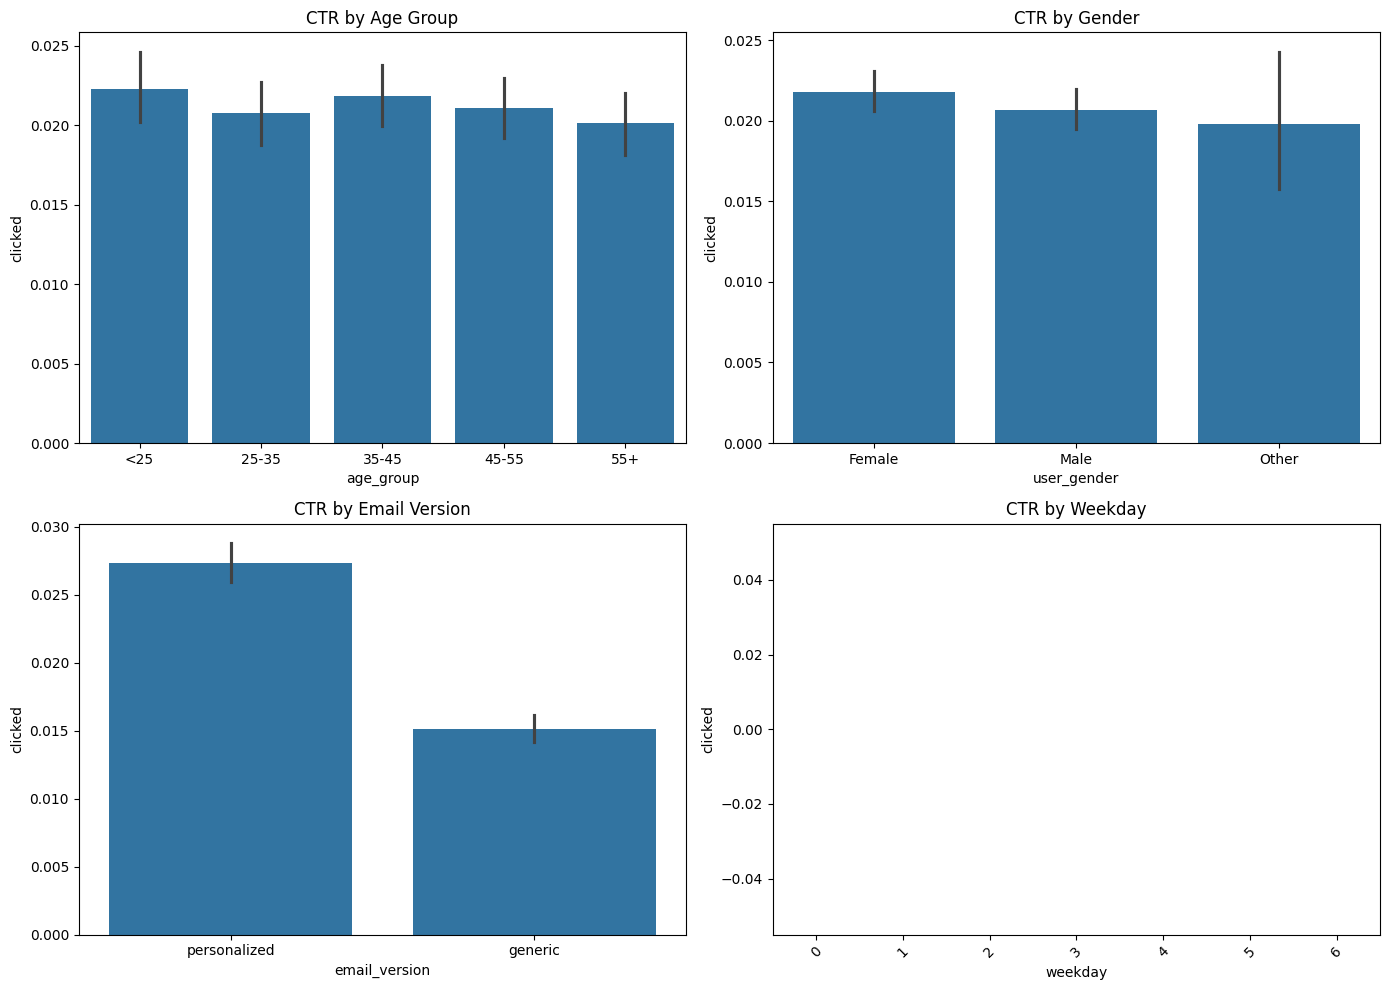

In [40]:
# 📌 Explanation:
# Visualize CTR across different user segments

# Generate and visualize click behavior by segments
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Simulate age and gender if missing
df['user_age'] = np.random.randint(18, 65, size=len(df))
df['user_gender'] = np.random.choice(['Male', 'Female', 'Other'], size=len(df), p=[0.48, 0.48, 0.04])
df['age_group'] = pd.cut(df['user_age'], bins=[0, 25, 35, 45, 55, 100], labels=['<25', '25-35', '35-45', '45-55', '55+'])

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

sns.barplot(data=df, x='age_group', y='clicked', ax=axs[0, 0])
axs[0, 0].set_title("CTR by Age Group")

sns.barplot(data=df, x='user_gender', y='clicked', ax=axs[0, 1])
axs[0, 1].set_title("CTR by Gender")

sns.barplot(data=df, x='email_version', y='clicked', ax=axs[1, 0])
axs[1, 0].set_title("CTR by Email Version")

sns.barplot(data=df, x='weekday', y='clicked', ax=axs[1, 1])
axs[1, 1].set_title("CTR by Weekday")
axs[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()